# Project: Advanced Lane Finding

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
# Load nessesery modules and set up
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

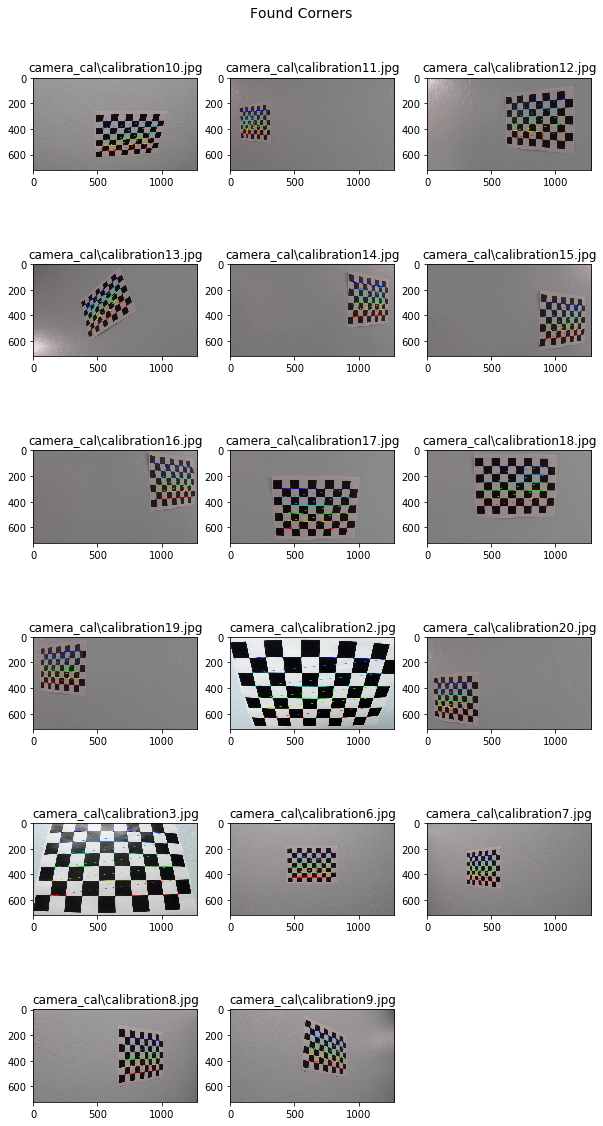

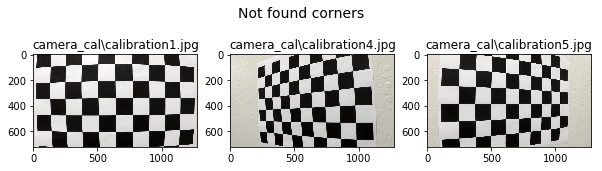

In [2]:
x_corners = 9 
y_corners = 6

objp = np.zeros((y_corners * x_corners,3), np.float32)
objp[:,:2] = np.mgrid[0:x_corners, 0:y_corners].T.reshape(-1,2)

objpoints = [] 
imgpoints = [] 

images = glob.glob('camera_cal/calibration*.jpg')

not_found = []

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.9,'Found Corners ', fontsize=14, ha='center')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (x_corners,y_corners), None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_corners,y_corners), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        
    else:
        not_found.append(fname)
plt.show()

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.56 ,'Not found corners ', fontsize=14, ha='center')
for i, p in enumerate(not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) 
    plt.title(p)

plt.show()


## Apply a distortion correction to raw images.

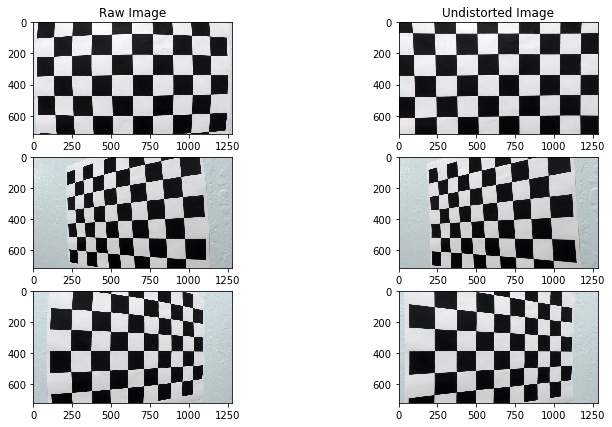

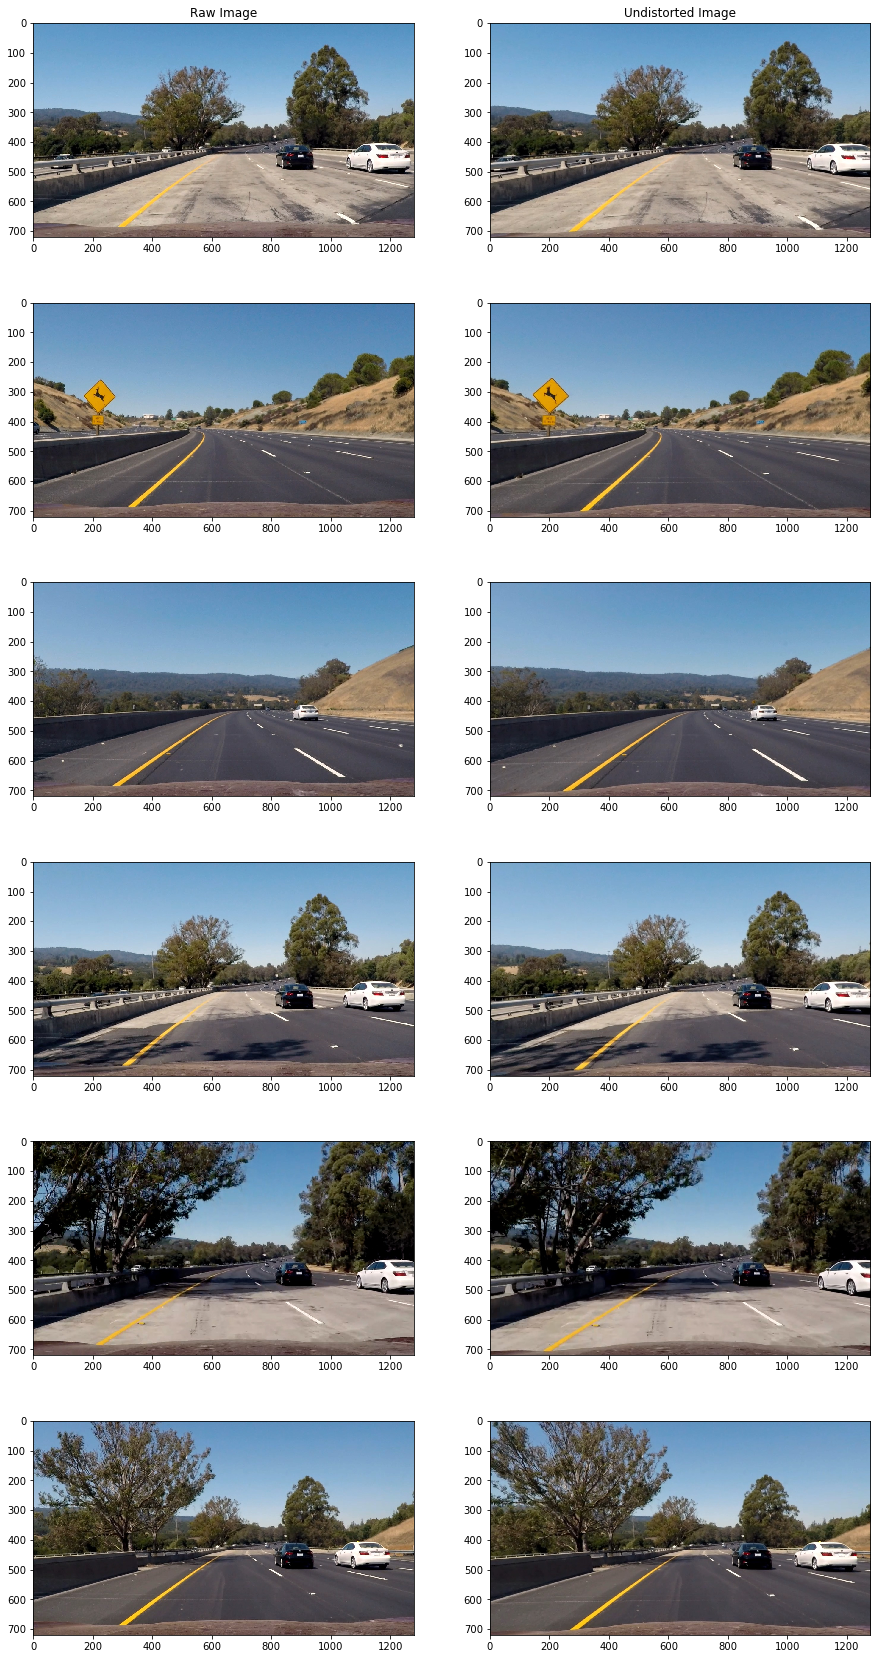

In [32]:
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = []
for i in not_found:
    img.append(cv2.imread(i))

    
img_size = (img[0].shape[1], img[0].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

plt.figure(figsize=(12, 7))

counter = 1
for i in img:
    plt.subplot(3, 2, counter)
    plt.imshow(i)
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(3, 2, counter)
    plt.imshow(undistort(i, mtx, dist))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1
   
test_images_files = glob.glob('test_images/test*.jpg')
test_images = []
for i in test_images_files:
    test_images.append(cv2.imread(i))


plt.figure(figsize=(15, 30))
counter = 1

for i in test_images:
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(undistort(i, mtx, dist), cv2.COLOR_BGR2RGB))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1

## Use color transforms, gradients, etc., to create a thresholded binary image.

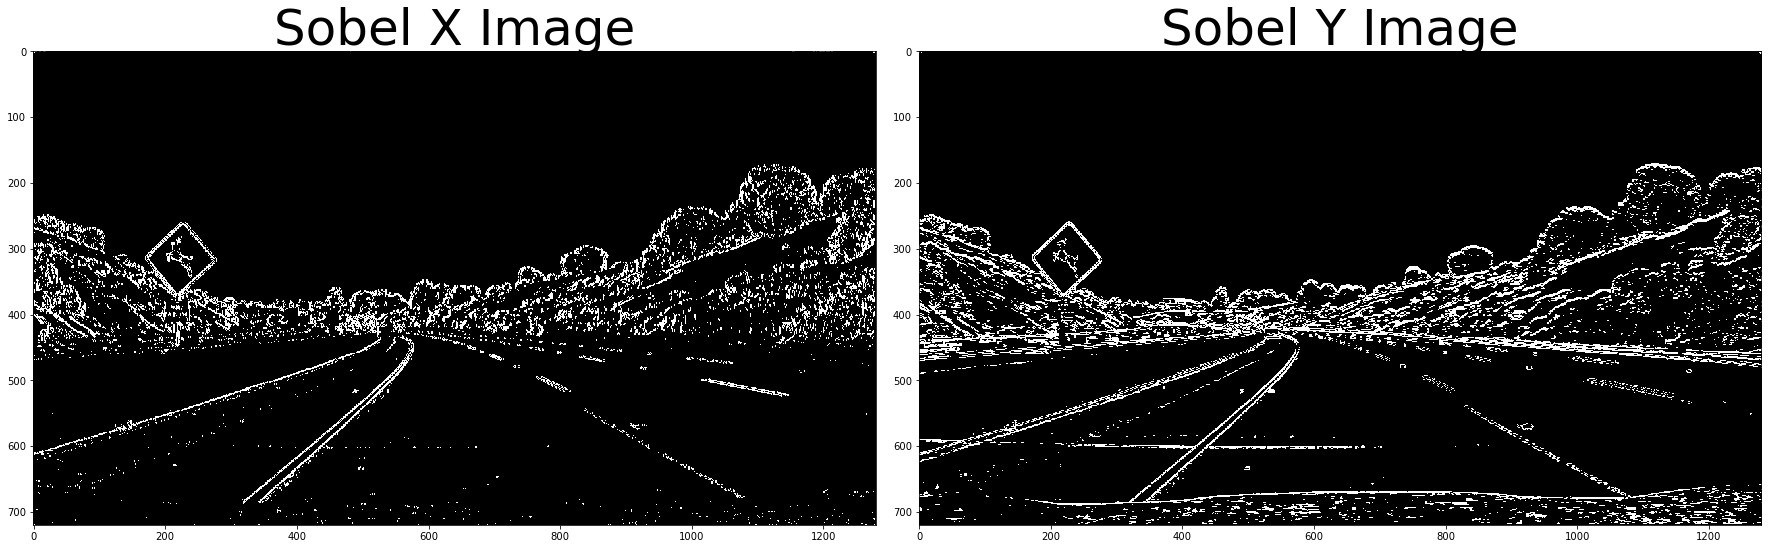

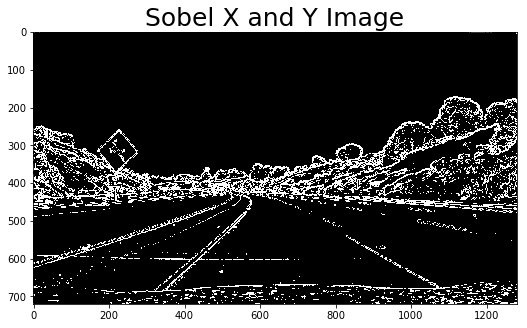

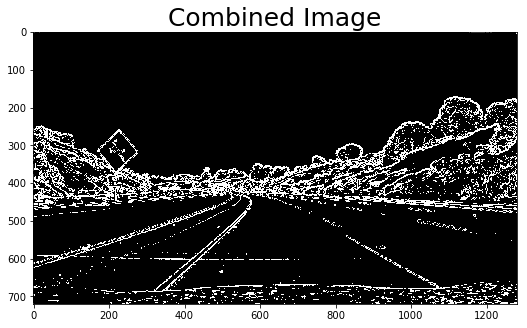

In [33]:
img = cv2.imread('test_images/test2.jpg')
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

## test results

abs_sobel_x_img = abs_sobel_thresh(img, 'x', 3, (20, 100))
abs_sobel_y_img = abs_sobel_thresh(img, 'y', 3, (20, 100))
abs_sobel_xy_img = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(abs_sobel_x_img, cmap='gray')
ax1.set_title('Sobel X Image', fontsize=50)
ax2.imshow(abs_sobel_y_img, cmap='gray')
ax2.set_title('Sobel Y Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.figure(figsize=(15, 5))
plt.imshow(abs_sobel_xy_img, cmap='gray')
plt.title('Sobel X and Y Image', fontsize=25)



gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))
dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2))


combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(15, 5))
plt.imshow(combined, cmap='gray')
plt.title('Combined Image', fontsize=25)

## Apply a perspective transform to rectify binary image ("birds-eye view").

## Detect lane pixels and fit to find the lane boundary.

## Determine the curvature of the lane and vehicle position with respect to center.

## Warp the detected lane boundaries back onto the original image.

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.